GARCH Modelling for Microsoft Stock

In [1]:
!pip install yfinance arch matplotlib statsmodels --quiet

# Importing the libraries we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from arch import arch_model
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

from arch.univariate import ARX, FIGARCH
from statsmodels.tsa.stattools import adfuller

plt.style.use('ggplot')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.4 MB/s eta 0:00:00


In [2]:
# Dictionary of stocks that we picked
stocks = {
    "AAPL": "Apple Inc.", # Foreign Stock
    "MSFT": "Microsoft Corporation", # Foreign Stock
    "RELIANCE.NS": "Reliance Industries", # Indian Stock
    "TCS.NS": "Tata Consultancy Services", # Indian Stock
    "HDFCBANK.NS": "HDFC Bank" # Indian Stock
}

# In this notebook, we are analysing Microsoft
selected_ticker = "MSFT"

# You can change to one of: "AAPL", "RELIANCE.NS", "TCS.NS", or "HDFCBANK.NS"
# We have attached separate notebooks for those too
print(f"Selected stock: {selected_ticker} – {stocks[selected_ticker]}")

Selected stock: MSFT – Microsoft Corporation


In [3]:
# 10 Year time horizon
start_date = "2015-01-01"
end_date = "2025-01-01"

data = yf.download(selected_ticker, start=start_date, end=end_date, auto_adjust=False)

# We are using daily log returns: ln(P_t / P_{t-1})
data['Log_Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
returns = data['Log_Returns'].dropna()

print(f"Downloaded data for {selected_ticker}. Number of observations: {len(returns)}")
print(returns.head())

[*********************100%***********************]  1 of 1 completed

Downloaded data for MSFT. Number of observations: 2515
Date
2015-01-05   -0.009238
2015-01-06   -0.014786
2015-01-07    0.012626
2015-01-08    0.028993
2015-01-09   -0.008441
Name: Log_Returns, dtype: float64


In [4]:
def stationary_test(returns):
    print("Performing ADF test...")
    adf_result = adfuller(returns)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    if adf_result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is non-stationary")
    print(f"Critical Values:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {value}")

stationary_test(returns)

Performing ADF test...
ADF Statistic: -17.283829334994067
p-value: 5.7599914532573896e-30
Series is stationary
Critical Values:
  1%: -3.432962135264372
  5%: -2.862694028699462
  10%: -2.567384333962417


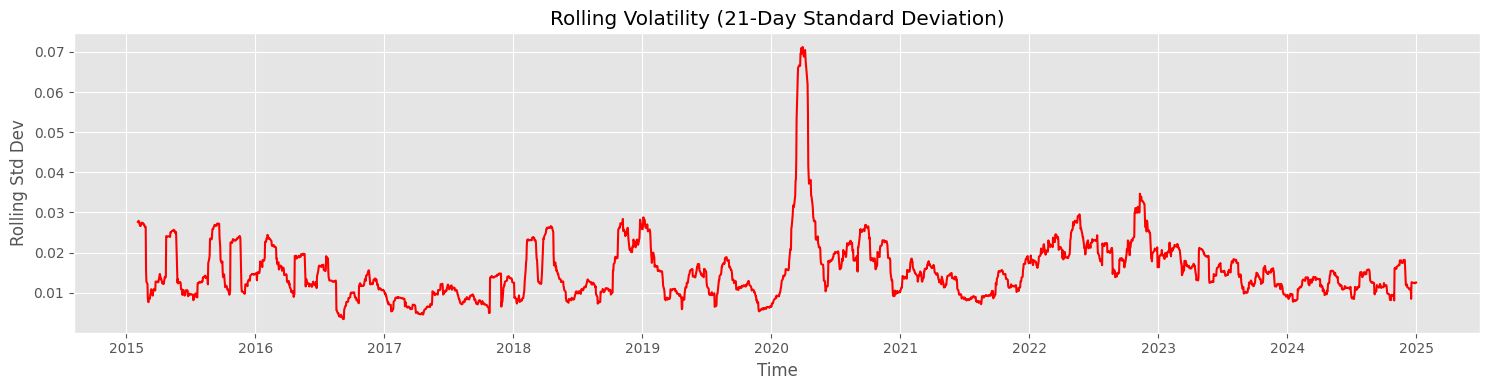

In [5]:
rolling_vol = returns.rolling(window=21).std()

plt.figure(figsize=(15, 4))
plt.plot(rolling_vol, color='red')
plt.title('Rolling Volatility (21-Day Standard Deviation)')
plt.xlabel('Time')
plt.ylabel('Rolling Std Dev')
plt.grid(True)
plt.tight_layout()
plt.show()

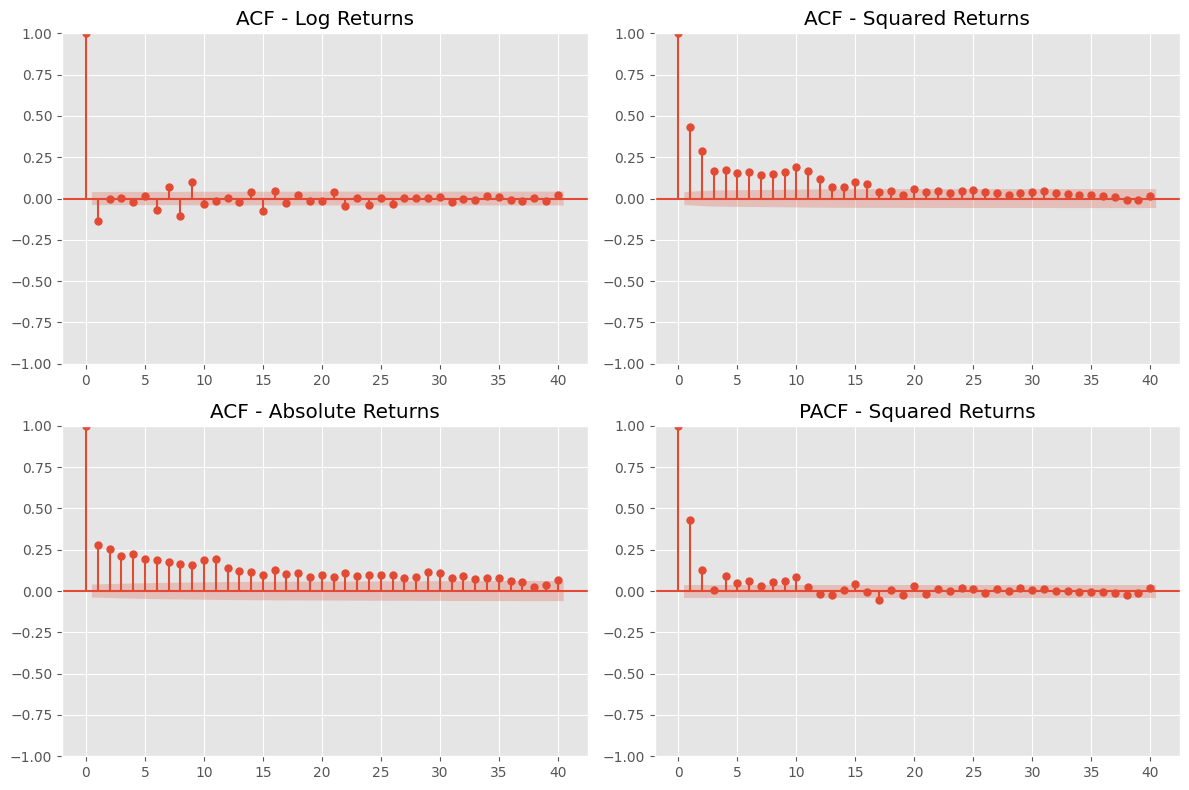

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(returns, ax=axs[0, 0], lags=40)
axs[0, 0].set_title("ACF - Log Returns")

plot_acf(returns**2, ax=axs[0, 1], lags=40)
axs[0, 1].set_title("ACF - Squared Returns")

plot_acf(np.abs(returns), ax=axs[1, 0], lags=40)
axs[1, 0].set_title("ACF - Absolute Returns")

plot_pacf(returns**2, ax=axs[1, 1], lags=40)
axs[1, 1].set_title("PACF - Squared Returns")

plt.tight_layout()
plt.show()

In [7]:
# We are fitting an AR(1) model using AutoReg
ar_model = AutoReg(returns, lags=1).fit()
print(ar_model.summary())
residuals = ar_model.resid

                            AutoReg Model Results                             
Dep. Variable:            Log_Returns   No. Observations:                 2515
Model:                     AutoReg(1)   Log Likelihood                6687.220
Method:               Conditional MLE   S.D. of innovations              0.017
Date:                Sat, 12 Apr 2025   AIC                         -13368.439
Time:                        17:33:59   BIC                         -13350.950
Sample:                             1   HQIC                        -13362.092
                                 2515                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0011      0.000      3.161      0.002       0.000       0.002
Log_Returns.L1    -0.1382      0.020     -6.996      0.000      -0.177      -0.099
                                    

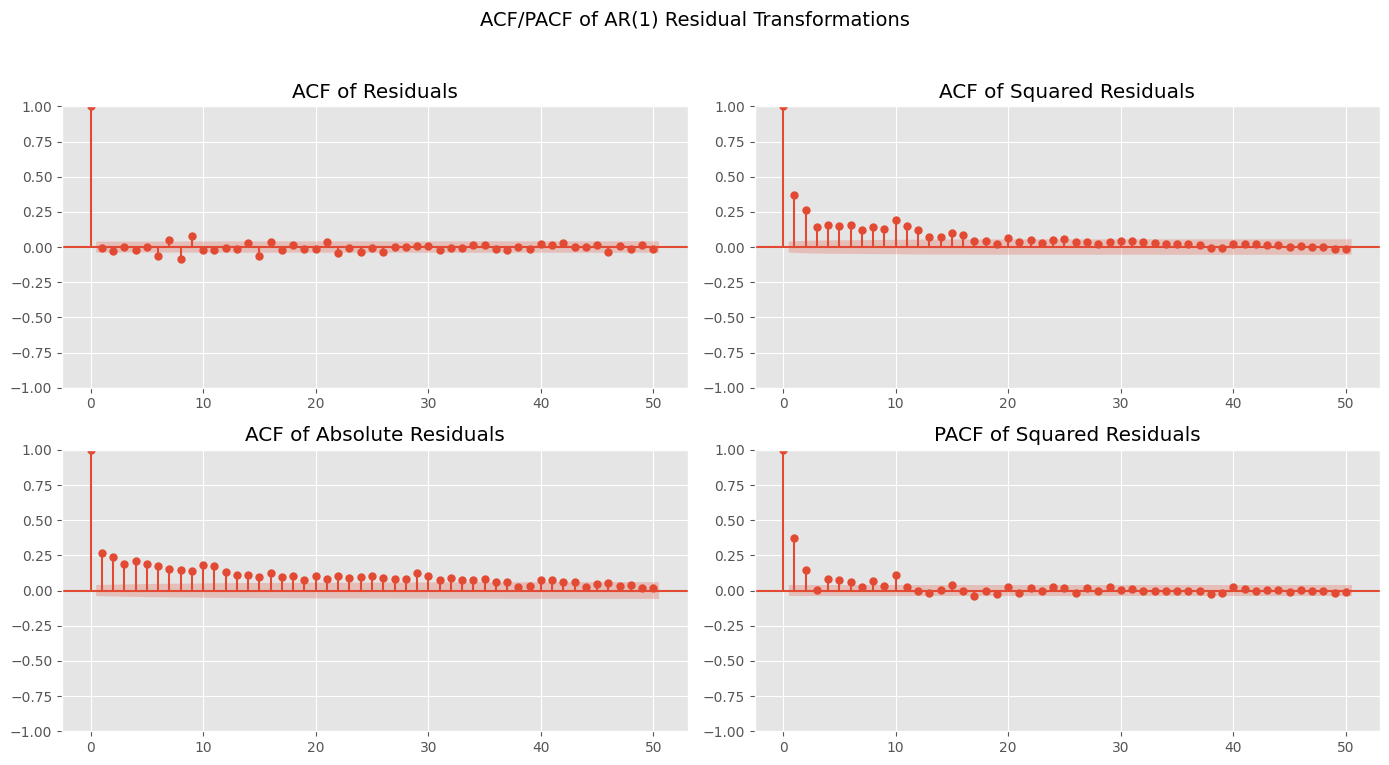

In [8]:
squared_resid = residuals**2
abs_resid = np.abs(residuals)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle("ACF/PACF of AR(1) Residual Transformations", fontsize=14)

plot_acf(residuals, lags=50, ax=axes[0, 0])
axes[0, 0].set_title("ACF of Residuals")

plot_acf(squared_resid, lags=50, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Squared Residuals")

plot_acf(abs_resid, lags=50, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Absolute Residuals")

plot_pacf(squared_resid, lags=50, ax=axes[1, 1])
axes[1, 1].set_title("PACF of Squared Residuals")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [9]:
# Ljung-Box Test
lb_test = acorr_ljungbox(residuals**2, lags=[10], return_df=True)
print("\nARCH Effect Test (Ljung-Box on Squared Residuals):")
print(lb_test)


ARCH Effect Test (Ljung-Box on Squared Residuals):
      lb_stat      lb_pvalue
10  982.22022  1.263682e-204


In [10]:
# Here, we are selecting the best GARCH model parameters p, q with bruteforce and validating with AIC, BIC values
print("\nGARCH Model Order Selection:")
best_aic = np.inf
best_order = None
best_model = None

for p in range(1, 3):
    for q in range(1, 3):
        model_candidate = arch_model(residuals, p=p, q=q)
        res_candidate = model_candidate.fit(disp="off")
        print(f'GARCH({p},{q}) - AIC: {res_candidate.aic:.2f}, BIC: {res_candidate.bic:.2f}')
        if res_candidate.aic < best_aic:
            best_aic = res_candidate.aic
            best_order = (p, q)
            best_model = res_candidate

print(f"\n Best GARCH Order (by AIC): GARCH{best_order}")
print(best_model.summary())


GARCH Model Order Selection:
GARCH(1,1) - AIC: -13830.80, BIC: -13807.48
GARCH(1,2) - AIC: -13837.38, BIC: -13808.23
GARCH(2,1) - AIC: -13822.18, BIC: -13793.03
GARCH(2,2) - AIC: -13830.49, BIC: -13795.52

 Best GARCH Order (by AIC): GARCH(1, 2)
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6923.69
Distribution:                  Normal   AIC:                          -13837.4
Method:            Maximum Likelihood   BIC:                          -13808.2
                                        No. Observations:                 2514
Date:                Sat, Apr 12 2025   Df Residuals:                     2513
Time:                        17:34:00   Df Model:                            1
                                  Mean Mod

AR model parameters: ['const', 'Log_Returns.L1']
Forecasting for time step t = 1911
Using fallback lag parameter name: Log_Returns.L1


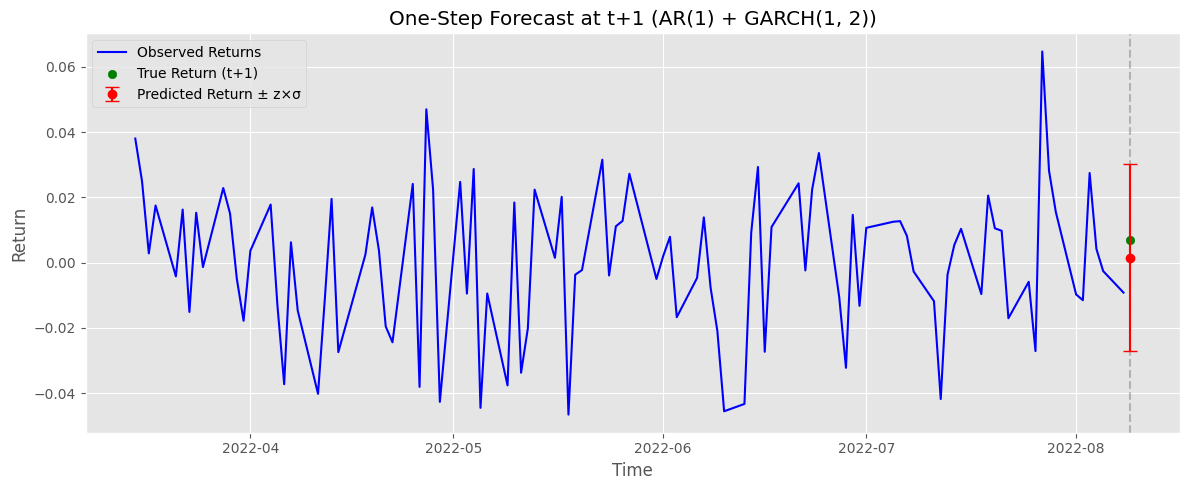

Predicted Mean at t+1: 0.0014
95% CI Range: [-0.0272, 0.0301]
Actual Return at t+1: 0.0070


In [11]:
# If the return series has no name, we have to rename it
if returns.name is None:
    returns.name = "Log_Returns"

print("AR model parameters:", ar_model.params.index.tolist())

# Choose a random time step t such that t+1 exists
t = np.random.randint(1000, len(returns) - 2)

print(f"Forecasting for time step t = {t}")

confidence_level = 0.95  # For a 95% confidence interval
z = norm.ppf(1 - (1 - confidence_level) / 2)

# Forecast volatility at t+1 using the best GARCH model.
forecast = best_model.forecast(start=returns.index[t], horizon=1)
predicted_vol = np.sqrt(forecast.variance.values[-1, 0])

# Determine the correct lag parameter name:
if "L1.Log_Returns" in ar_model.params.index:
    lag_param = "L1.Log_Returns"
else:
    # Fallback: use the second parameter's name (assuming the first is 'const')
    lag_param = ar_model.params.index[1]
    print(f"Using fallback lag parameter name: {lag_param}")

# Forecast mean using the AR(1) model (predicted_mean = const + phi * last_return)
last_return = returns.iloc[t - 1]
predicted_mean = ar_model.params['const'] + ar_model.params[lag_param] * last_return

# True return at t+1
true_return = returns.iloc[t + 1]

# Plot a context window showing the forecast at t+1
context_range = returns.index[t - 100:t + 2]
plt.figure(figsize=(12, 5))
plt.plot(context_range[:-1], returns.iloc[t - 100:t + 1], label='Observed Returns', color='blue')
plt.scatter(returns.index[t + 1], true_return, color='green', label='True Return (t+1)', zorder=5)
plt.errorbar(returns.index[t + 1], predicted_mean, yerr=z * predicted_vol,
             fmt='o', color='red', label='Predicted Return ± z×σ', capsize=5, zorder=5)
plt.axvline(returns.index[t + 1], linestyle='--', color='gray', alpha=0.5)
plt.title(f"One-Step Forecast at t+1 (AR(1) + GARCH{best_order})")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Predicted Mean at t+1: {predicted_mean:.4f}")
print(f"95% CI Range: [{predicted_mean - z*predicted_vol:.4f}, {predicted_mean + z*predicted_vol:.4f}]")
print(f"Actual Return at t+1: {true_return:.4f}")

Using fallback AR lag parameter: Log_Returns.L1


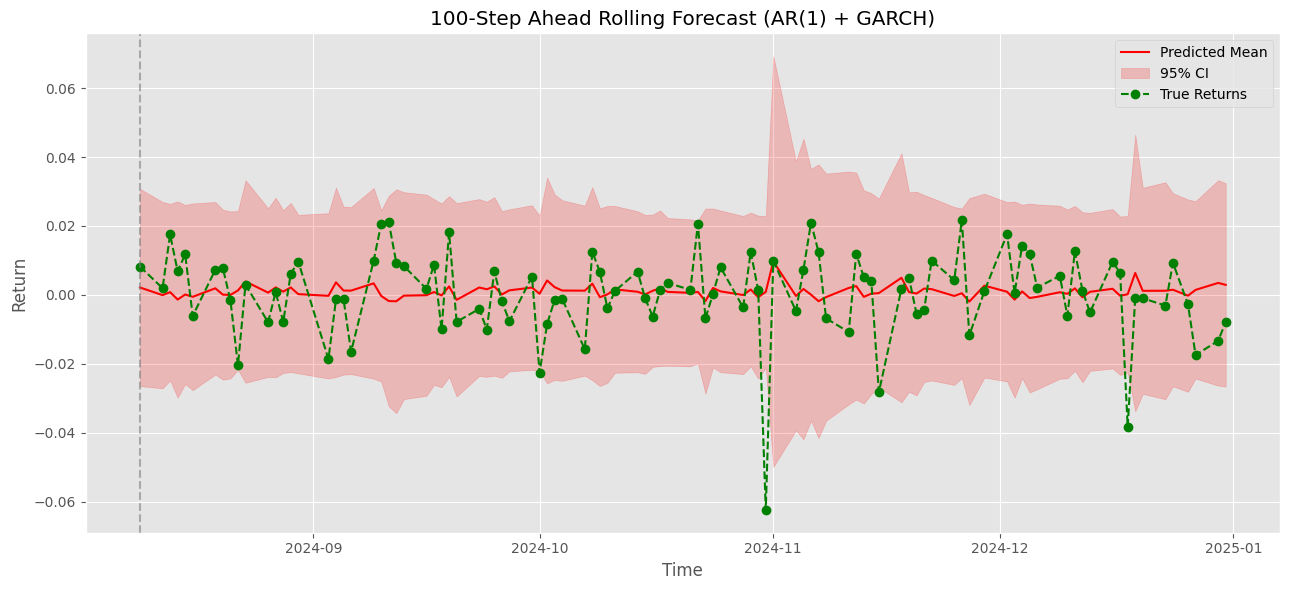

In [12]:
# Define forecast horizon
k = 100
confidence_level = 0.95  # For a 95% confidence interval
z = norm.ppf(1 - (1 - confidence_level) / 2)

# Extract AR(1) parameters; ensure returns has a name so the parameter is as expected.
ar_params = ar_model.params
if "L1.Log_Returns" in ar_params.index:
    lag_param = "L1.Log_Returns"
else:
    lag_param = ar_params.index[1]
    print("Using fallback AR lag parameter:", lag_param)

# Extract parameters from the best GARCH model
garch_params = best_model.params
omega_val = garch_params['omega']
alpha1_val = garch_params.get('alpha[1]', 0)
alpha2_val = garch_params.get('alpha[2]', 0)  # Will be 0 if the model is GARCH(1,1)
beta1_val = garch_params.get('beta[1]', 0)
beta2_val = garch_params.get('beta[2]', 0)

# Initialize history using the last two observations for returns, residuals, and variance.
history_returns = list(returns.iloc[-2:])
history_resids = list(ar_model.resid.iloc[-2:])
history_sigma2 = list(best_model.conditional_volatility.iloc[-2:]**2)

predicted_means = []
predicted_stds = []
true_returns = []

# Iteratively forecast k steps ahead.
for i in range(k):
    # Forecast mean using AR(1)
    pred_mean = ar_params['const'] + ar_params[lag_param] * history_returns[-1]
    predicted_means.append(pred_mean)

    # Forecast variance using GARCH dynamics
    sigma2_pred = (omega_val +
                   alpha1_val * history_resids[-1]**2 +
                   alpha2_val * (history_resids[-2]**2 if len(history_resids) >= 2 else 0) +
                   beta1_val * history_sigma2[-1] +
                   beta2_val * (history_sigma2[-2] if len(history_sigma2) >= 2 else 0))
    predicted_stds.append(np.sqrt(sigma2_pred))

    # For evaluation: use the last k observed returns for comparison
    idx = len(returns) - k + i
    true_returns.append(returns.iloc[idx])

    # Update history
    resid = true_returns[-1] - pred_mean
    history_resids.append(resid)
    history_sigma2.append(sigma2_pred)
    history_returns.append(true_returns[-1])

# Create an index for the forecast horizon
forecast_index = returns.index[-k:]

plt.figure(figsize=(13, 6))
plt.plot(forecast_index, predicted_means, color='red', label='Predicted Mean')
plt.fill_between(forecast_index,
                 np.array(predicted_means) - z * np.array(predicted_stds),
                 np.array(predicted_means) + z * np.array(predicted_stds),
                 color='red', alpha=0.2, label=f'{confidence_level*100:.0f}% CI')
plt.plot(forecast_index, true_returns, marker='o', linestyle='--', color='green', label='True Returns')
plt.axvline(returns.index[-k], linestyle='--', color='gray', alpha=0.6)
plt.title(f"{k}-Step Ahead Rolling Forecast (AR(1) + GARCH)")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


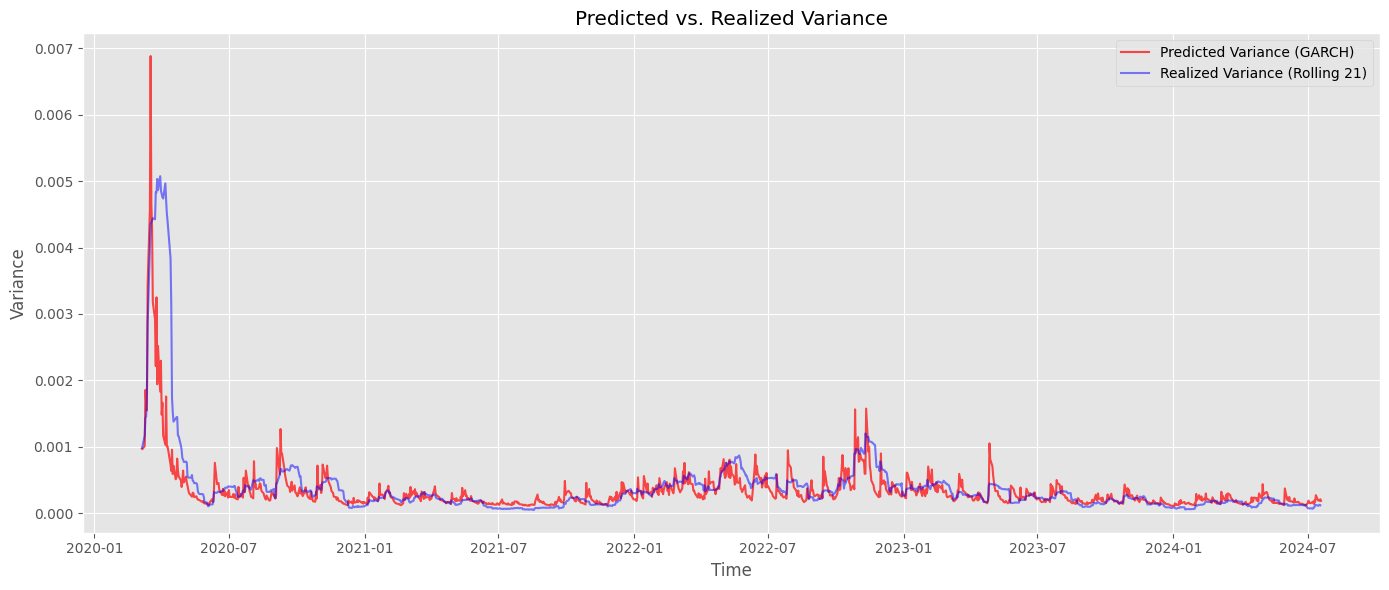

In [13]:
predicted_var_series = best_model.conditional_volatility ** 2
window = 21  # 21-day rolling window for realized variance
realized_var_series = returns.rolling(window=window).var()

plt.figure(figsize=(14, 6))
plt.plot(predicted_var_series[1300:2400], label='Predicted Variance (GARCH)', color='red', alpha=0.7)
plt.plot(realized_var_series[1300:2400], label=f'Realized Variance (Rolling {window})', color='blue', alpha=0.5)
plt.title('Predicted vs. Realized Variance')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Total number of observations
n_returns = len(returns)
print(f"Total number of return observations: {n_returns}")

# Define start and end indices for the coverage test.
# For example, we use the last 20% of the data for testing:
start_t = int(n_returns * 0.8)
end_t = n_returns - 2  # Ensures that t+1 exists

print(f"Testing range: start_t = {start_t}, end_t = {end_t}")

confidence_level = 0.95
z = norm.ppf(1 - (1 - confidence_level) / 2)
print(f"z-value: {z}")

# Ensure correct AR lag parameter name is determined.
ar_params = ar_model.params
if "L1.Log_Returns" in ar_params.index:
    lag_param = "L1.Log_Returns"
else:
    lag_param = ar_params.index[1]
    print(f"Using fallback AR lag parameter: {lag_param}")

count_in_ci = 0
total_checks = 0

for t in range(start_t, end_t):
    if t % 500 == 0:
        print(f"Processing t = {t} / {end_t}")
    # Forecast mean using AR(1)
    predicted_mean = ar_model.params['const'] + ar_model.params[lag_param] * returns.iloc[t - 1]

    # Forecast volatility at t+1 using the best GARCH model
    forecast = best_model.forecast(start=returns.index[t], horizon=1)
    predicted_vol = np.sqrt(forecast.variance.values[-1, 0])

    # Compute confidence interval for t+1
    ci_lower = predicted_mean - z * predicted_vol
    ci_upper = predicted_mean + z * predicted_vol

    true_ret = returns.iloc[t + 1]
    if ci_lower <= true_ret <= ci_upper:
        count_in_ci += 1
    total_checks += 1

coverage = count_in_ci / total_checks
print(f"User-defined Confidence Level: {confidence_level*100:.1f}%")
print(f"Observed Coverage: {coverage*100:.2f}% ({count_in_ci} out of {total_checks} instances)")


Total number of return observations: 2515
Testing range: start_t = 2012, end_t = 2513
z-value: 1.959963984540054
Using fallback AR lag parameter: Log_Returns.L1
Processing t = 2500 / 2513
User-defined Confidence Level: 95.0%
Observed Coverage: 95.21% (477 out of 501 instances)


In [15]:
# ---- 1. Fitting EGARCH (normal) on AR(1) residuals ----
try:
    egarch_model = arch_model(residuals, vol='EGARCH', p=1, q=1, dist='normal')
    egarch_fit = egarch_model.fit(disp="off")
    print("\n--- EGARCH (normal) Model Summary ---")
    print(egarch_fit.summary())
except Exception as e:
    print("\nEGARCH model could not be estimated:", e)

# ---- 2. Fitting FIGARCH (normal) on AR(1) residuals ----
try:
    # Create a FIGARCH specification
    figarch_spec = ARX(residuals, lags=0)
    figarch_spec.volatility = FIGARCH(p=1, q=1)

    # Fit the model (it estimates the fractional d parameter)
    figarch_fit = figarch_spec.fit(disp="off")
    print("\n--- FIGARCH (as FIGARCH mimic) Model Summary ---")
    print(figarch_fit.summary())

except Exception as e:
    print("\nFIGARCH model could not be estimated:", e)

# ---- 3. Fitting GJR-GARCH (normal) on AR(1) residuals ----
try:
    # Set o=1 to enable the asymmetry (leverage) term.
    gjr_model = arch_model(residuals, vol='GARCH', p=1, o=1, q=1, dist='normal')
    gjr_fit = gjr_model.fit(disp="off")
    print("\n--- GJR-GARCH (normal) Model Summary ---")
    print(gjr_fit.summary())
except Exception as e:
    print("\nGJR-GARCH model could not be estimated:", e)

# ---- 4. Fitting GARCH-M (GARCH in Mean) on raw returns ----
try:
    # For GARCH-M, we include lagged conditional volatility as an exogenous regressor.
    # Use the conditional volatility from your best GARCH model, shifted by one day.
    lagged_vol = best_model.conditional_volatility.shift(1).dropna()
    # Align returns with the lagged_vol (same index)
    returns_for_garchm = returns.loc[lagged_vol.index]

    # Fit a GARCH-in-Mean model using mean='ARX' with no AR lags.
    garchm_model = arch_model(returns_for_garchm, mean='ARX', lags=0, x=lagged_vol,
                              vol='GARCH', p=1, q=1, dist='normal')
    garchm_fit = garchm_model.fit(disp="off")
    print("\n--- GARCH-M (in-Mean) Model Summary ---")
    print(garchm_fit.summary())
except Exception as e:
    print("\nGARCH-M model could not be estimated:", e)



--- EGARCH (normal) Model Summary ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                6930.83
Distribution:                  Normal   AIC:                          -13853.7
Method:            Maximum Likelihood   BIC:                          -13830.3
                                        No. Observations:                 2514
Date:                Sat, Apr 12 2025   Df Residuals:                     2513
Time:                        17:34:03   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.244

In [16]:
# Calculate actual realized volatility (once)
actual_vol_series = np.sqrt(returns.rolling(window=20).var())
common_index = actual_vol_series.index[1300:2400]

# Helper function for RMSE calculationcalculation
def compute_rmse(predicted_vol, actual_vol, index_slice):
    return np.sqrt(mean_squared_error(actual_vol.loc[index_slice], predicted_vol.loc[index_slice]))

# Dictionary to store RMSEs
rmse_results = {}

# 1. EGARCH
if 'egarch_fit' in locals():
    egarch_vol = egarch_fit.conditional_volatility
    rmse_results['EGARCH'] = compute_rmse(egarch_vol, actual_vol_series, common_index)

# 2. FIGARCH
if 'figarch_fit' in locals():
    figarch_vol = figarch_fit.conditional_volatility
    rmse_results['FIGARCH'] = compute_rmse(figarch_vol, actual_vol_series, common_index)

# 3. GJR-GARCH
if 'gjr_fit' in locals():
    gjr_vol = gjr_fit.conditional_volatility
    rmse_results['GJR-GARCH'] = compute_rmse(gjr_vol, actual_vol_series, common_index)

# 4. GARCH-M
if 'garchm_fit' in locals():
    garchm_vol = garchm_fit.conditional_volatility
    rmse_results['GARCH-M'] = compute_rmse(garchm_vol, actual_vol_series, common_index)

# 5. GARCH
if 'best_model' in locals():
    garch_vol = best_model.conditional_volatility
    rmse_results['GARCH'] = compute_rmse(garch_vol, actual_vol_series, common_index)

print("\n--- RMSE Comparison ---")
for model_name, rmse_val in rmse_results.items():
    print(f"{model_name} RMSE: {rmse_val:.4f}")


--- RMSE Comparison ---
EGARCH RMSE: 0.0050
FIGARCH RMSE: 0.0053
GJR-GARCH RMSE: 0.0037
GARCH-M RMSE: 0.0044
GARCH RMSE: 0.0049


In [17]:
print("\nAdditional Model Comparison:")
variant_models = {
    "EGARCH": egarch_fit if 'egarch_fit' in globals() and egarch_fit is not None else None,
    "FIGARCH": figarch_fit if 'figarch_fit' in globals() and figarch_fit is not None else None,
    "GJR-GARCH": gjr_fit if 'gjr_fit' in globals() and gjr_fit is not None else None,
    "GARCH-M": garchm_fit if 'garchm_fit' in globals() and garchm_fit is not None else None,
    "GARCH": best_model if 'best_model' in globals() and best_model is not None else None
}

for label, fit in variant_models.items():
    if fit is not None:
        print(f"{label}: AIC = {fit.aic:.2f}, BIC = {fit.bic:.2f}")
    else:
        print(f"{label}: Model not available")


Additional Model Comparison:
EGARCH: AIC = -13853.66, BIC = -13830.34
FIGARCH: AIC = -13865.91, BIC = -13836.77
GJR-GARCH: AIC = -13855.57, BIC = -13826.42
GARCH-M: AIC = -13833.75, BIC = -13804.61
GARCH: AIC = -13837.38, BIC = -13808.23


AR model parameters: ['const', 'Log_Returns.L1']
Using fallback lag parameter name: Log_Returns.L1

One-step forecast will use t = 2003 (forecast at t+1)
z-value: 1.9600

================= Variant: EGARCH =================


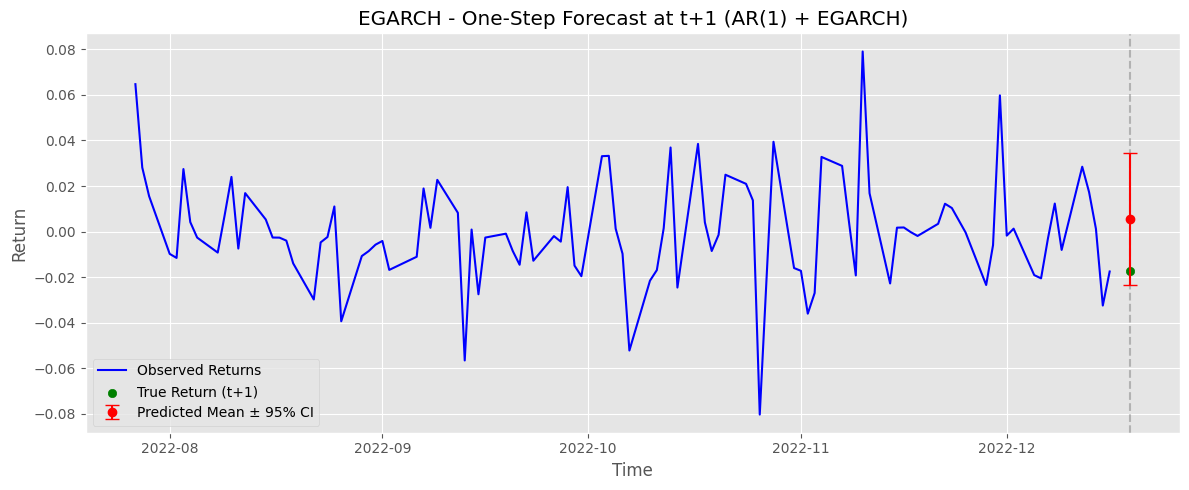

EGARCH - One-Step Forecast Results:
Predicted Mean at t+1: 0.0056
95% CI Range: [-0.0236, 0.0347]
Actual Return at t+1: -0.0175



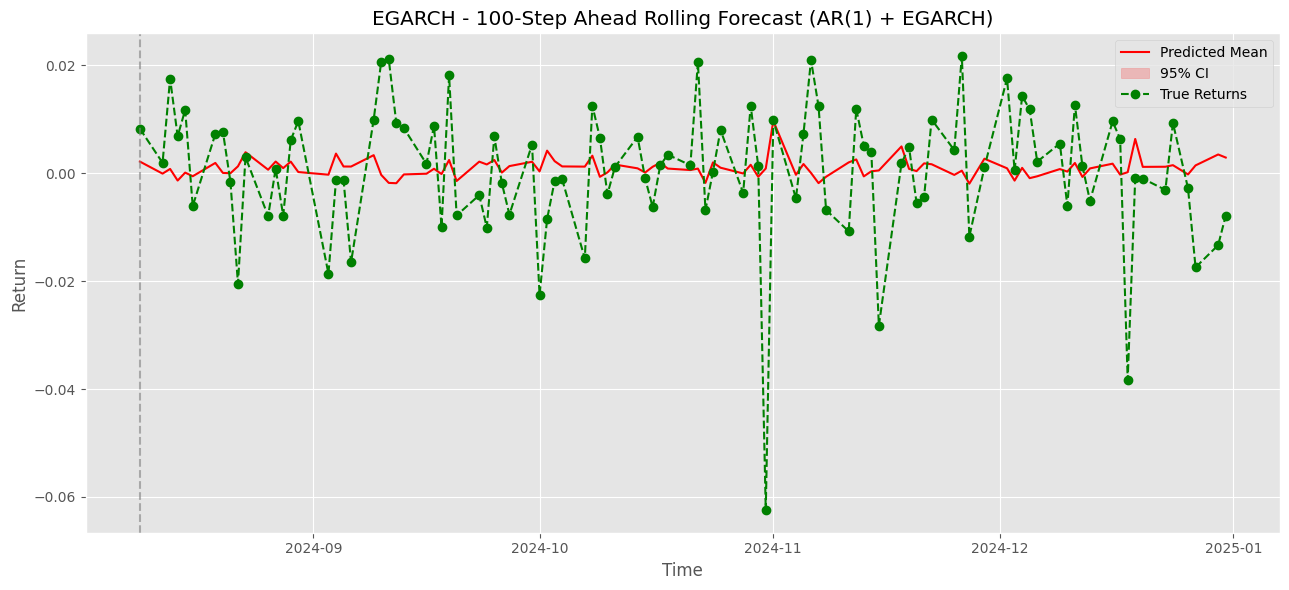

EGARCH - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = nan, max = nan
Upper Bound: min = nan, max = nan



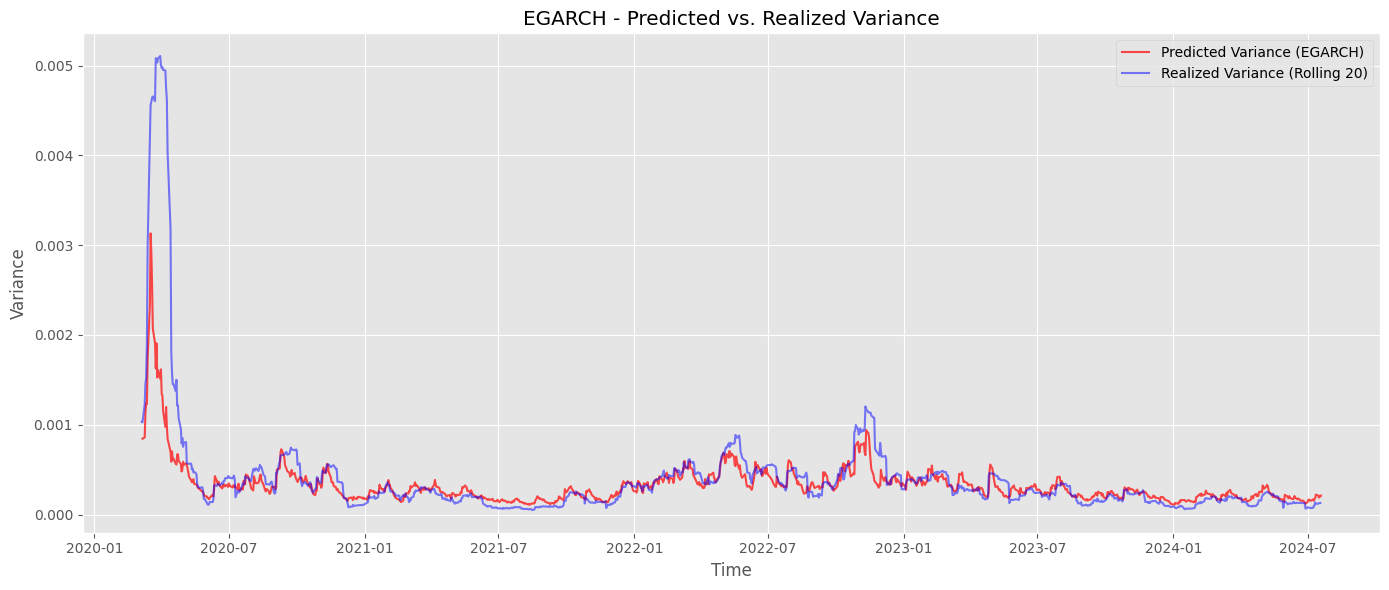


================= Variant: FIGARCH =================


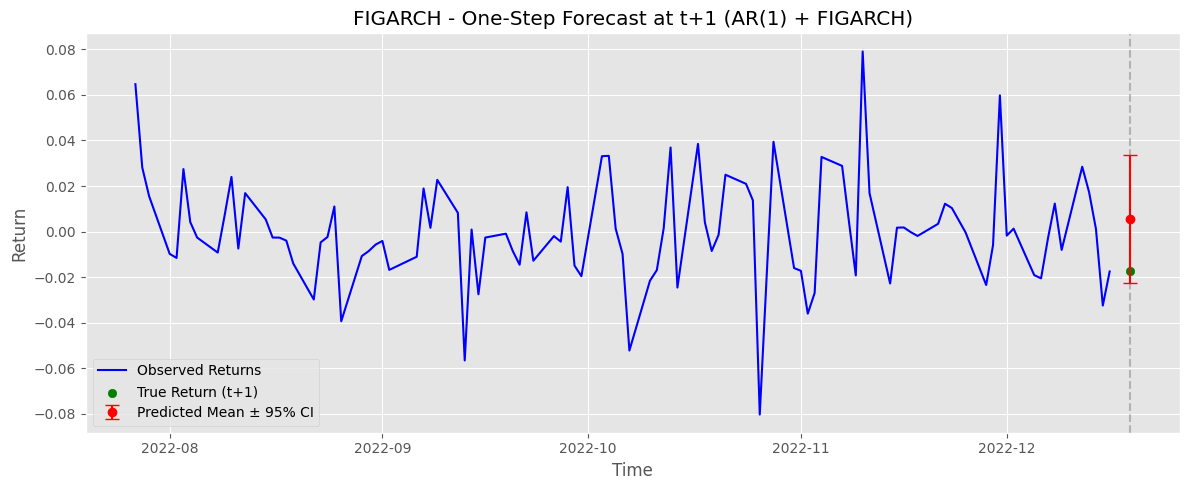

FIGARCH - One-Step Forecast Results:
Predicted Mean at t+1: 0.0056
95% CI Range: [-0.0226, 0.0337]
Actual Return at t+1: -0.0175



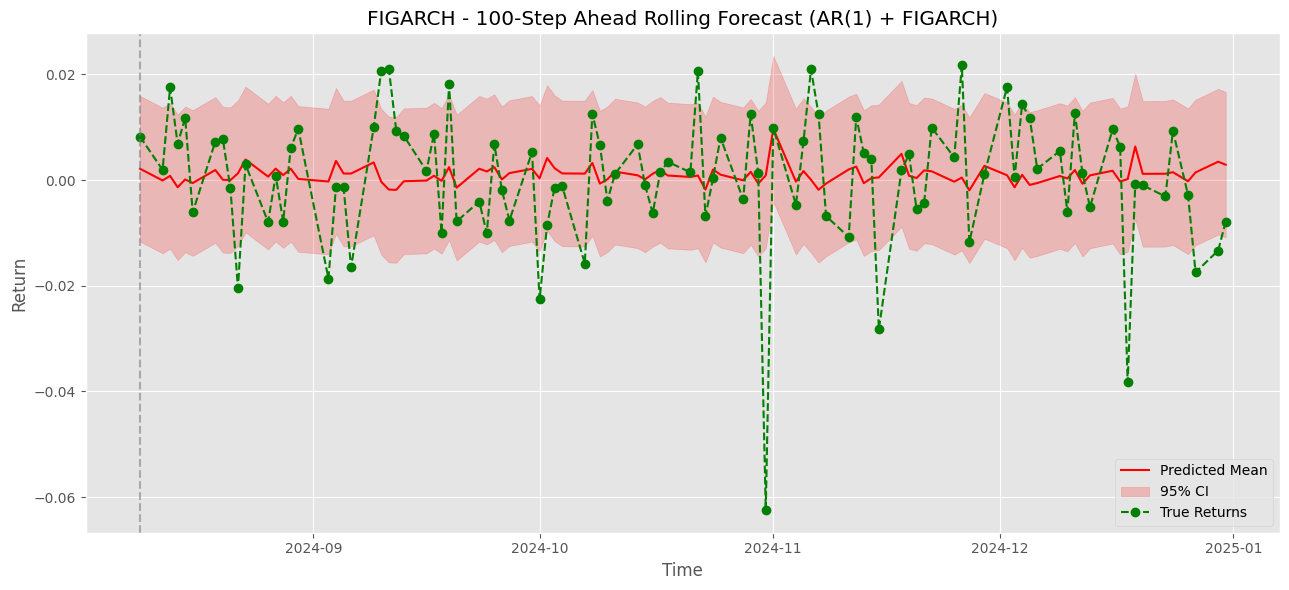

FIGARCH - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = -0.0157, max = -0.0041
Upper Bound: min = 0.0118, max = 0.0235



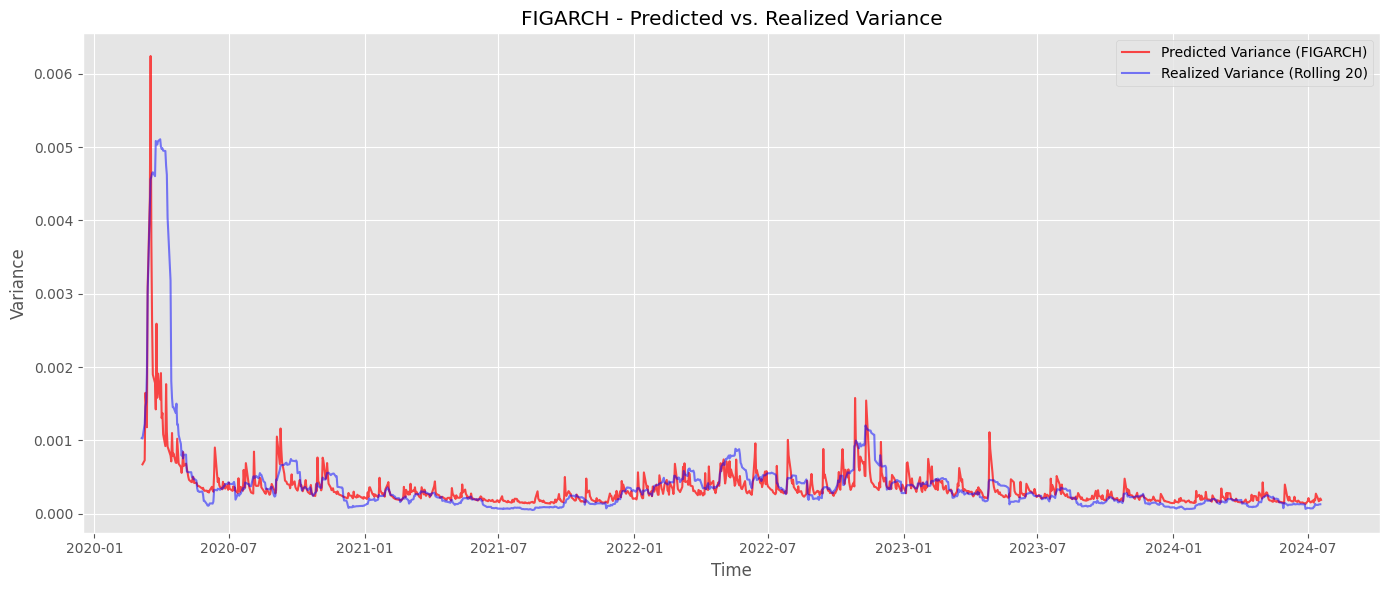


================= Variant: GJR-GARCH =================


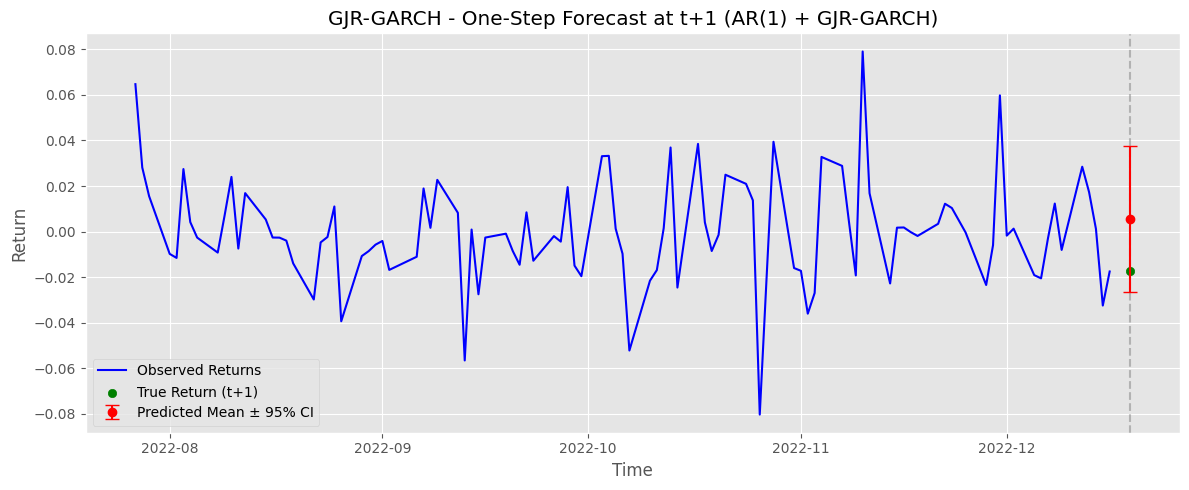

GJR-GARCH - One-Step Forecast Results:
Predicted Mean at t+1: 0.0056
95% CI Range: [-0.0266, 0.0377]
Actual Return at t+1: -0.0175



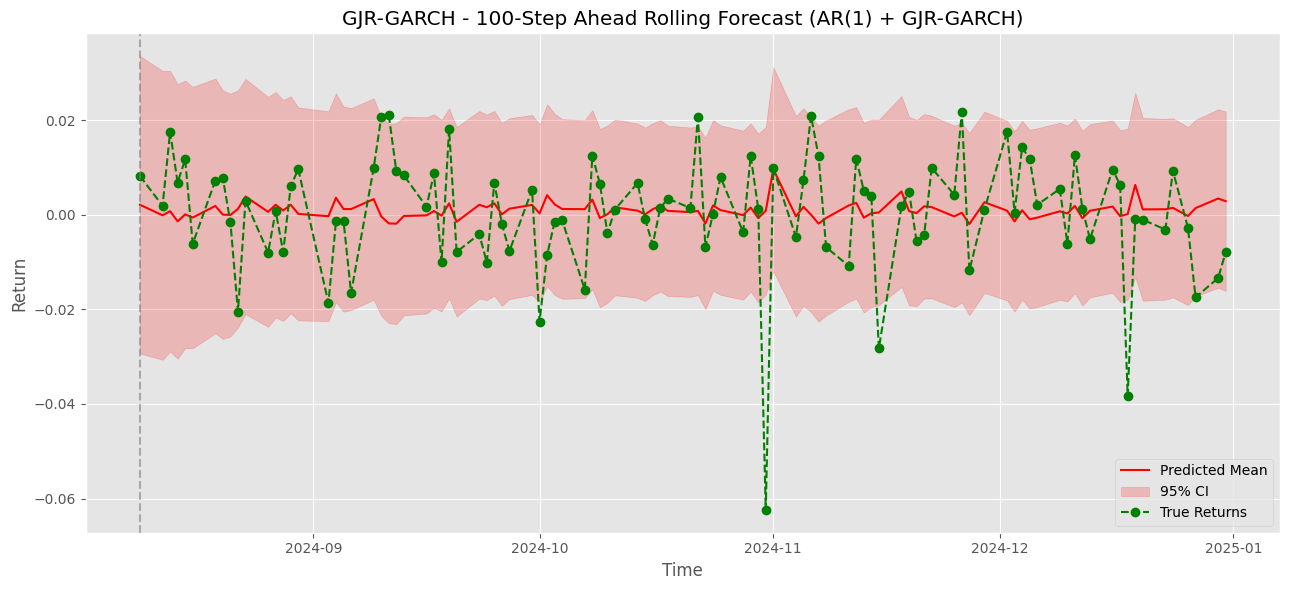

GJR-GARCH - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = -0.0306, max = -0.0119
Upper Bound: min = 0.0164, max = 0.0336



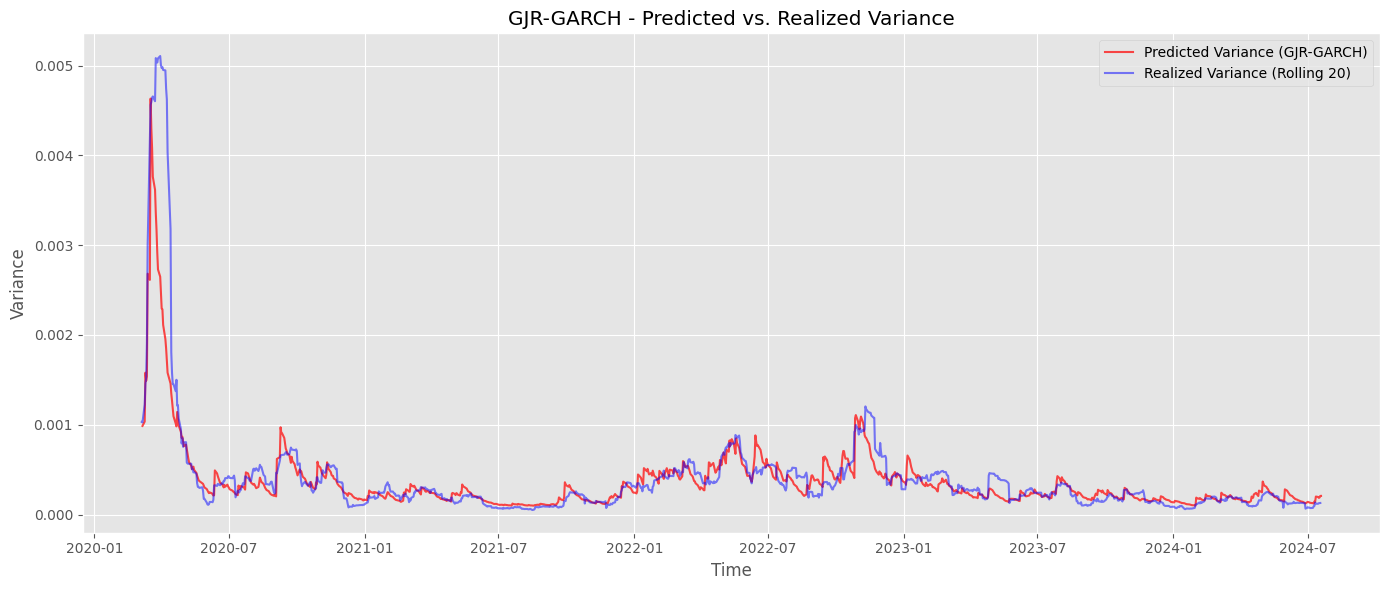


================= Variant: GARCH-M =================
Forecast error in GARCH-M: x is None but the model contains exogenous variables. You must provide expected values to use for the exogenous variables to construct forecasts.


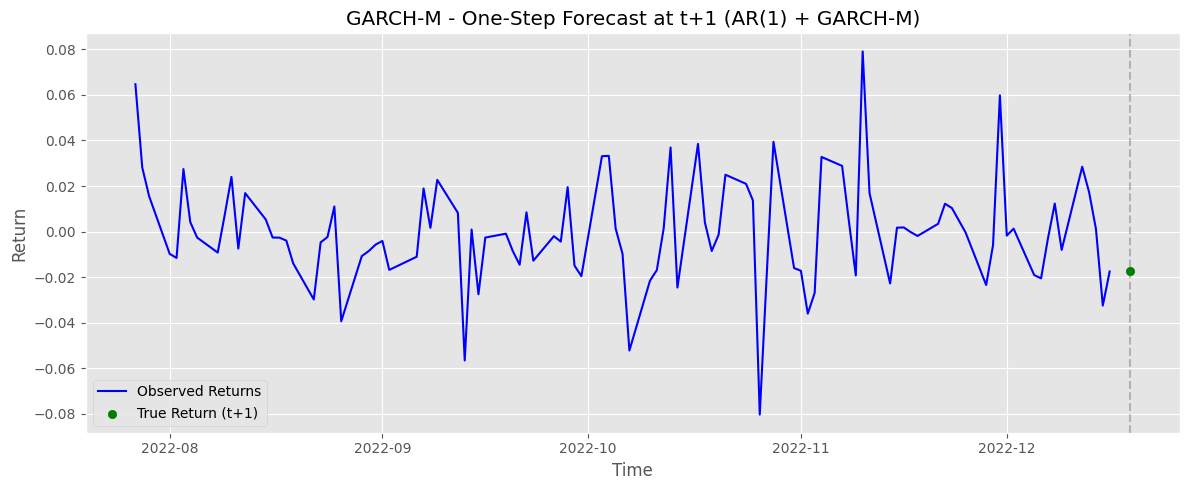

GARCH-M - One-Step Forecast Results:
Predicted Mean at t+1: 0.0056
Actual Return at t+1: -0.0175



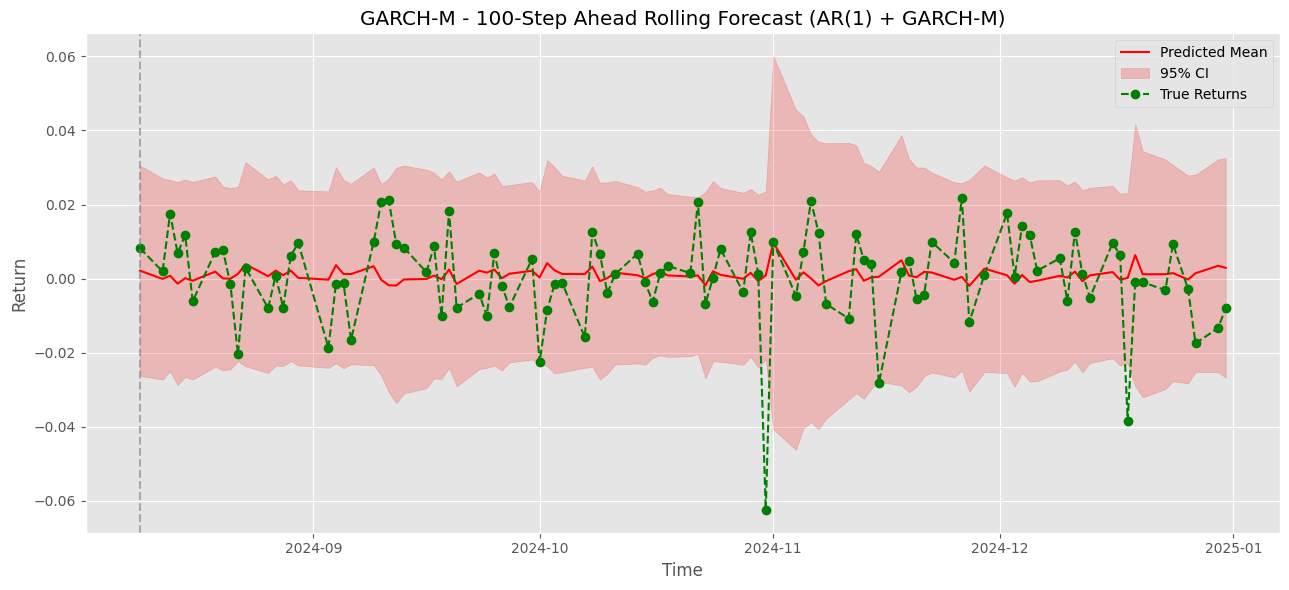

GARCH-M - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = -0.0462, max = -0.0203
Upper Bound: min = 0.0220, max = 0.0601



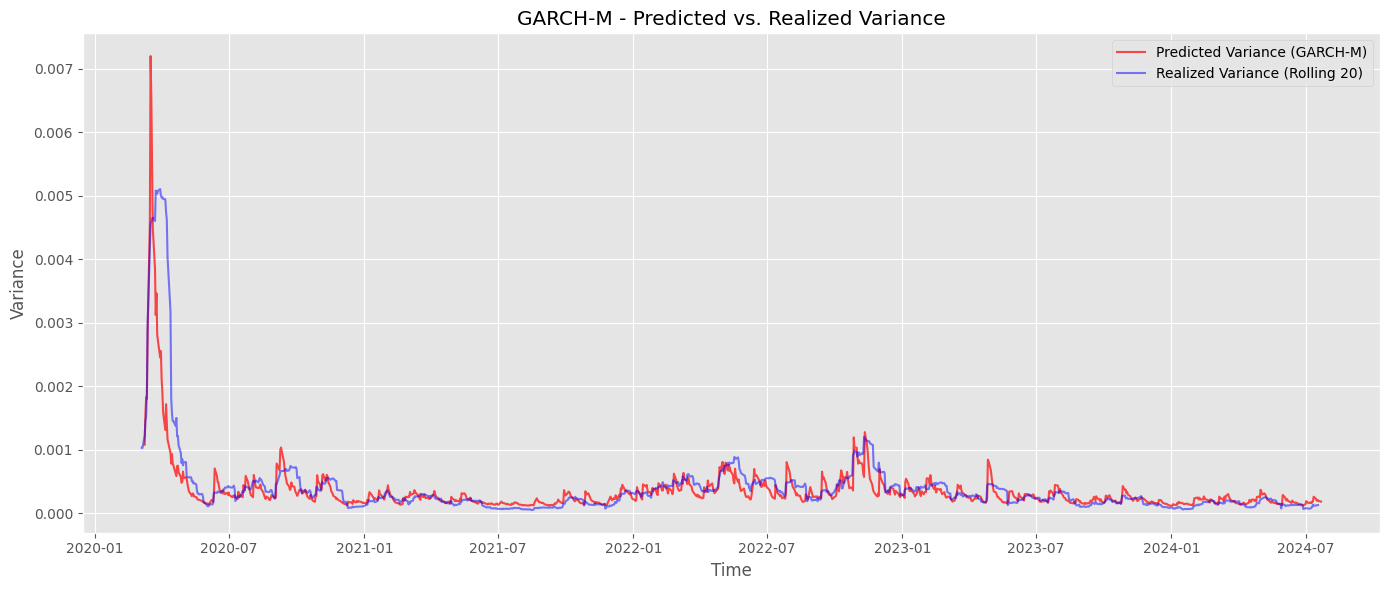

In [18]:
variants = {
    "EGARCH": egarch_fit,
    "FIGARCH": figarch_fit,
    "GJR-GARCH": gjr_fit,
    "GARCH-M": garchm_fit,
}

if returns.name is None:
    returns.name = "Log_Returns"

print("AR model parameters:", ar_model.params.index.tolist())

if "L1.Log_Returns" in ar_model.params.index:
    lag_param = "L1.Log_Returns"
else:
    lag_param = ar_model.params.index[1]
    print(f"Using fallback lag parameter name: {lag_param}")

t_forecast = np.random.randint(1000, len(returns) - 2)
print(f"\nOne-step forecast will use t = {t_forecast} (forecast at t+1)")

# We are using same confidence level for the forecast intervals.
confidence_level = 0.95
z = norm.ppf(1 - (1 - confidence_level) / 2)
print(f"z-value: {z:.4f}")

k = 100

for variant_name, model_fit in variants.items():
    print(f"\n================= Variant: {variant_name} =================")

    ### Graph 1: One-Step Forecast
    try:
        # We are using the variant model's forecast method for one-step ahead.
        # (For GARCH-M, assume its forecast method works similarly; otherwise, you may need to use model_fit.forecast on raw returns.)
        forecast_var = model_fit.forecast(start=returns.index[t_forecast], horizon=1)
        predicted_vol = np.sqrt(forecast_var.variance.values[-1, 0])
    except Exception as e:
        print(f"Forecast error in {variant_name}: {e}")
        predicted_vol = np.nan

    # Forecast mean using the AR(1) model (common to all variants).
    last_return = returns.iloc[t_forecast - 1]
    predicted_mean = ar_model.params['const'] + ar_model.params[lag_param] * last_return
    true_return = returns.iloc[t_forecast + 1]

    # Plot one-step forecast (Graph 1)
    context_range = returns.index[t_forecast - 100 : t_forecast + 2]
    plt.figure(figsize=(12, 5))
    plt.plot(context_range[:-1], returns.iloc[t_forecast - 100:t_forecast + 1], label='Observed Returns', color='blue')
    plt.scatter(returns.index[t_forecast + 1], true_return, color='green', label='True Return (t+1)', zorder=5)
    if not np.isnan(predicted_vol):
        plt.errorbar(returns.index[t_forecast + 1], predicted_mean, yerr=z * predicted_vol,
                     fmt='o', color='red', label=f'Predicted Mean ± {confidence_level*100:.0f}% CI', capsize=5, zorder=5)
    plt.axvline(returns.index[t_forecast + 1], linestyle='--', color='gray', alpha=0.5)
    plt.title(f"{variant_name} - One-Step Forecast at t+1 (AR(1) + {variant_name})")
    plt.xlabel("Time")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{variant_name} - One-Step Forecast Results:")
    print(f"Predicted Mean at t+1: {predicted_mean:.4f}")
    if not np.isnan(predicted_vol):
        print(f"95% CI Range: [{predicted_mean - z*predicted_vol:.4f}, {predicted_mean + z*predicted_vol:.4f}]")
    print(f"Actual Return at t+1: {true_return:.4f}\n")

    ### Graph 2: Multi-Step Rolling Forecast
    # Extract parameters from the variant model
    var_params = model_fit.params
    omega_val = var_params['omega']
    alpha1_val = var_params.get('alpha[1]', 0)
    alpha2_val = var_params.get('alpha[2]', 0)
    beta1_val = var_params.get('beta[1]', 0)
    beta2_val = var_params.get('beta[2]', 0)

    # Initialize history (we use the AR(1) residuals procedure similar to our standard GARCH forecast)
    # For models fitted on AR(1) residuals; for GARCH-M the logic is similar.
    try:
        history_returns = list(returns.iloc[-2:])
        history_resids = list(ar_model.resid.iloc[-2:])
        history_sigma2 = list(model_fit.conditional_volatility.iloc[-2:]**2)
    except Exception as e:
        print(f"Error initializing history for {variant_name}: {e}")
        continue

    pred_means = []
    pred_stds = []
    true_forecast_returns = []

    # Rolling forecast loop for k steps ahead.
    for i in range(k):
        # Forecast mean using AR(1)
        pred_mean = ar_model.params['const'] + ar_model.params[lag_param] * history_returns[-1]
        pred_means.append(pred_mean)
        sigma2_pred = (omega_val +
                       alpha1_val * history_resids[-1]**2 +
                       alpha2_val * (history_resids[-2]**2 if len(history_resids) >= 2 else 0) +
                       beta1_val * history_sigma2[-1] +
                       beta2_val * (history_sigma2[-2] if len(history_sigma2) >= 2 else 0))
        pred_stds.append(np.sqrt(sigma2_pred))
        idx = len(returns) - k + i  # use the last k observed returns for comparison
        true_forecast_returns.append(returns.iloc[idx])
        # Update history
        resid = true_forecast_returns[-1] - pred_mean
        history_resids.append(resid)
        history_sigma2.append(sigma2_pred)
        history_returns.append(true_forecast_returns[-1])

    forecast_index = returns.index[-k:]

    plt.figure(figsize=(13, 6))
    plt.plot(forecast_index, pred_means, color='red', label='Predicted Mean')
    plt.fill_between(forecast_index,
                     np.array(pred_means) - z * np.array(pred_stds),
                     np.array(pred_means) + z * np.array(pred_stds),
                     color='red', alpha=0.2, label=f'{confidence_level*100:.0f}% CI')
    plt.plot(forecast_index, true_forecast_returns, marker='o', linestyle='--', color='green', label='True Returns')
    plt.axvline(returns.index[-k], linestyle='--', color='gray', alpha=0.6)
    plt.title(f"{variant_name} - {k}-Step Ahead Rolling Forecast (AR(1) + {variant_name})")
    plt.xlabel("Time")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate theconfidence interval bounds for each forecasted step.
    lower_ci = np.array(pred_means) - z * np.array(pred_stds)
    upper_ci = np.array(pred_means) + z * np.array(pred_stds)

    # Print summary of CI range.
    print(f"{variant_name} - Confidence Interval Summary for the {k}-step forecast:")
    print(f"Lower Bound: min = {lower_ci.min():.4f}, max = {lower_ci.max():.4f}")
    print(f"Upper Bound: min = {upper_ci.min():.4f}, max = {upper_ci.max():.4f}\n")

    ### Graph 3: Predicted vs. Realized Variance
    try:
        pred_var_series = model_fit.conditional_volatility ** 2
        window = 20  # 20-day rolling window for realized variance
        realized_var_series = returns.rolling(window=window).var()
        plt.figure(figsize=(14, 6))
        plt.plot(pred_var_series[1300:2400], label=f'Predicted Variance ({variant_name})', color='red', alpha=0.7)
        plt.plot(realized_var_series[1300:2400], label=f'Realized Variance (Rolling {window})', color='blue', alpha=0.5)
        plt.title(f"{variant_name} - Predicted vs. Realized Variance")
        plt.xlabel("Time")
        plt.ylabel("Variance")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"{variant_name} - Failed to plot Predicted vs. Realized Variance: {e}")
